In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

import os
import glob
from PIL import Image

In [2]:
torch.__version__

'1.13.0+cpu'

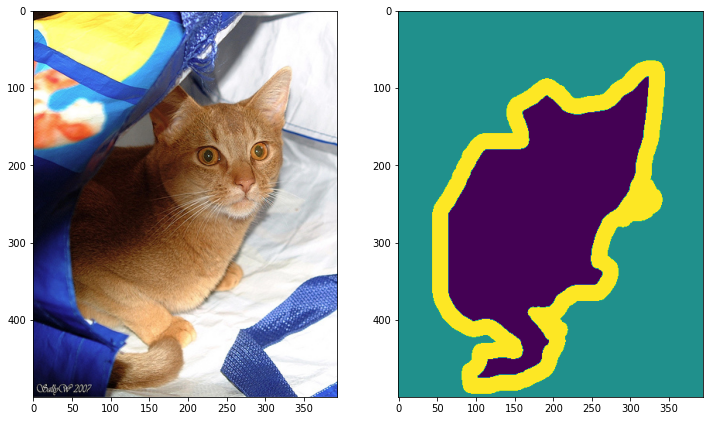

In [3]:
plt.figure(figsize=(12, 8))
label_img = Image.open(r'dataset\annotations\trimaps\Abyssinian_100.png')
label_np_img = np.array(label_img)
img = Image.open(r'dataset\images\Abyssinian_100.jpg')
np_img = np.array(img)
plt.subplot(1, 2, 1)
plt.imshow(np_img)
plt.subplot(1, 2, 2)
plt.imshow(label_np_img)
plt.show()

In [4]:
np_img.shape, label_np_img.shape

((500, 394, 3), (500, 394))

In [5]:
np.unique(label_np_img)

array([1, 2, 3], dtype=uint8)

### 创建输入

In [6]:
images = glob.glob('dataset/images/*.jpg')
annotations = glob.glob('dataset/annotations/trimaps/*.png')

In [7]:
print(len(images)), print(len(annotations))

7390
7390


(None, None)

In [8]:
np.random.seed(2022)
index = np.random.permutation(len(images))

images = np.array(images)[index]
annotations = np.array(annotations)[index]

In [9]:
sep = int(len(images)*0.8)
train_images = images[ :sep]
train_labels = annotations[ :sep]
test_images = images[sep: ]
test_labels = annotations[sep: ]

In [10]:
transform = transforms.Compose([
                    transforms.Resize((256, 256)),
                    transforms.ToTensor(),
])

In [11]:
class Oxford_dataset(data.Dataset):
    def __init__(self, img_paths, anno_paths):
        self.imgs = img_paths
        self.annos = anno_paths
        
    def __getitem__(self, index):
        img = self.imgs[index]
        anno = self.annos[index]
        pil_img = Image.open(img)
        pil_img = pil_img.convert("RGB")
        img_tensor = transform(pil_img)
        pil_anno = Image.open(anno)
        pil_anno = pil_anno.resize((256, 256)) 
        anno_tensor = torch.tensor(np.array(pil_anno), dtype=torch.int64)
        return img_tensor, torch.squeeze(anno_tensor)-1
    
    def __len__(self):
        return len(self.imgs)

In [12]:
BATCH_SIZE = 8

In [13]:
train_dataset = Oxford_dataset(train_images, train_labels)

In [14]:
test_dataset = Oxford_dataset(test_images, test_labels)

In [15]:
train_dl = data.DataLoader(
                           train_dataset,
                           batch_size=BATCH_SIZE,
                           shuffle=True,
)

In [16]:
test_dl = data.DataLoader(
                          test_dataset,
                          batch_size=BATCH_SIZE,
)

In [17]:
imgs_batch, annos_batch = next(iter(train_dl))

In [18]:
img = imgs_batch[0].permute(1,2,0).numpy()
anno = annos_batch[0].numpy()

In [19]:
np.unique(anno)

array([0, 1, 2], dtype=int64)

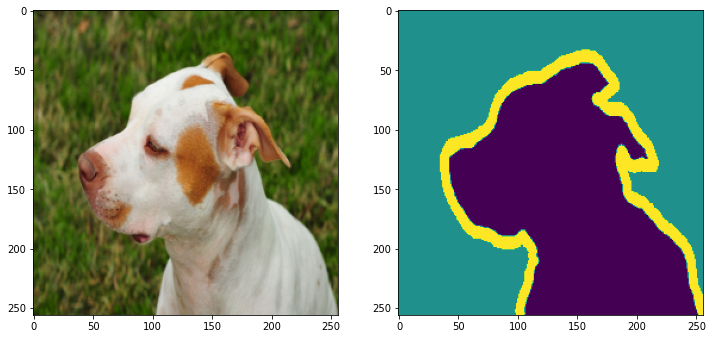

In [20]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(anno)
plt.show()

# UNET模型

In [21]:
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample, self).__init__()
        self.conv_relu = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, 
                                      kernel_size=3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(out_channels, out_channels, 
                                      kernel_size=3, padding=1),
                            nn.ReLU(inplace=True)
            )
        self.pool = nn.MaxPool2d(kernel_size=2)
    def forward(self, x, is_pool=True):
        if is_pool:
            x = self.pool(x)
        x = self.conv_relu(x)
        return x

In [22]:
class Upsample(nn.Module):
    def __init__(self, channels):
        super(Upsample, self).__init__()
        self.conv_relu = nn.Sequential(
                            nn.Conv2d(2*channels, channels, 
                                      kernel_size=3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(channels, channels,  
                                      kernel_size=3, padding=1),
                            nn.ReLU(inplace=True)
            )
        self.upconv_relu = nn.Sequential(
                               nn.ConvTranspose2d(channels, 
                                                  channels//2, 
                                                  kernel_size=3,
                                                  stride=2,
                                                  padding=1,
                                                  output_padding=1),
                               nn.ReLU(inplace=True)
            )
        
    def forward(self, x):
        x = self.conv_relu(x)
        x = self.upconv_relu(x)
        return x

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.down1 = Downsample(3, 64)
        self.down2 = Downsample(64, 128)
        self.down3 = Downsample(128, 256)
        self.down4 = Downsample(256, 512)
        self.down5 = Downsample(512, 1024)
        
        self.up = nn.Sequential(
                               nn.ConvTranspose2d(1024, 
                                                  512, 
                                                  kernel_size=3,
                                                  stride=2,
                                                  padding=1,
                                                  output_padding=1),
                               nn.ReLU(inplace=True)
            )
        
        self.up1 = Upsample(512)
        self.up2 = Upsample(256)
        self.up3 = Upsample(128)
        
        self.conv_2 = Downsample(128, 64)
        self.last = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        x1 = self.down1(x, is_pool=False)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)
        
        x5 = self.up(x5)
        
        x5 = torch.cat([x4, x5], dim=1)           # 32*32*1024
        x5 = self.up1(x5)                         # 64*64*256)
        x5 = torch.cat([x3, x5], dim=1)           # 64*64*512  
        x5 = self.up2(x5)                         # 128*128*128
        x5 = torch.cat([x2, x5], dim=1)           # 128*128*256
        x5 = self.up3(x5)                         # 256*256*64
        x5 = torch.cat([x1, x5], dim=1)           # 256*256*128
        
        x5 = self.conv_2(x5, is_pool=False)       # 256*256*64
        
        x5 = self.last(x5)                        # 256*256*3
        return x5

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [25]:
model = Net().to(device)

In [26]:
weight = torch.tensor([2, 1, 3], dtype=torch.float32)
weight = weight.to(device)
loss_fn = nn.CrossEntropyLoss(weight=weight)

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# 模型训练

In [28]:
def train(dataloader):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.type(torch.long).to(device) 
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            pred = torch.argmax(pred, dim=1)
            correct += (pred == y).type(torch.float).sum().item()
            train_loss += loss.item()
    train_loss /= num_batches
    correct /= size*256*256
    return train_loss, correct

In [29]:
def test(dataloader):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.type(torch.long).to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            pred = torch.argmax(pred, dim=1)
            correct += (pred == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size*256*256

    return test_loss, correct

In [30]:
def fit(epochs, train_dl, test_dl):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    for epoch in range(epochs):
        epoch_loss, epoch_acc = train(train_dl)
        epoch_test_loss, epoch_test_acc = test(test_dl)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc)
        template = ("epoch:{:2d}, train_loss: {:.5f}, train_acc: {:.1f}% , " 
                    "test_loss: {:.5f}, test_acc: {:.1f}%")
        print(template.format(
              epoch, epoch_loss, epoch_acc*100, epoch_test_loss, epoch_test_acc*100))
    print("Done!"),
    
    return train_loss, test_loss, train_acc, test_acc

# 训练

In [31]:
epochs = 50

In [32]:
train_loss, test_loss, train_acc, test_acc = fit(epochs, train_dl, test_dl)

C:\Users\guanghua\miniconda3\envs\tch19\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch: 0, train_loss: 0.93219, train_acc: 58.5% , test_loss: 0.85208, test_acc: 62.3%
epoch: 1, train_loss: 0.76803, train_acc: 70.5% , test_loss: 0.70261, test_acc: 70.7%
epoch: 2, train_loss: 0.62839, train_acc: 77.1% , test_loss: 0.57112, test_acc: 76.6%
epoch: 3, train_loss: 0.51215, train_acc: 81.8% , test_loss: 0.49948, test_acc: 82.6%
epoch: 4, train_loss: 0.45471, train_acc: 84.2% , test_loss: 0.46871, test_acc: 83.1%
epoch: 5, train_loss: 0.42220, train_acc: 85.4% , test_loss: 0.39738, test_acc: 86.0%
epoch: 6, train_loss: 0.39393, train_acc: 86.4% , test_loss: 0.40533, test_acc: 85.9%
epoch: 7, train_loss: 0.37906, train_acc: 87.0% , test_loss: 0.37849, test_acc: 86.7%
epoch: 8, train_loss: 0.35612, train_acc: 87.8% , test_loss: 0.39061, test_acc: 86.1%
epoch: 9, train_loss: 0.34050, train_acc: 88.5% , test_loss: 0.35774, test_acc: 87.5%
epoch:10, train_loss: 0.32665, train_acc: 88.9% , test_loss: 0.36526, test_acc: 88.2%
epoch:11, train_loss: 0.31095, train_acc: 89.4% , test

# 保存模型

In [33]:
PATH = 'unet_model.pth'

In [34]:
torch.save(model.state_dict(), PATH)

# 测试模型

In [35]:
my_model = Net()

In [36]:
my_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [37]:
num=3

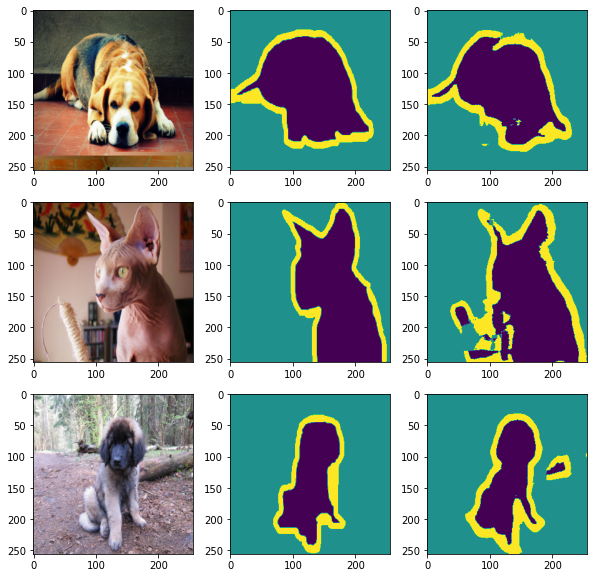

In [38]:
image, mask = next(iter(test_dl))
pred_mask = my_model(image)

plt.figure(figsize=(10, 10))
for i in range(num):
    plt.subplot(num, 3, i*num+1)
    plt.imshow(image[i].permute(1,2,0).cpu().numpy())
    plt.subplot(num, 3, i*num+2)
    plt.imshow(mask[i].cpu().numpy())
    plt.subplot(num, 3, i*num+3)
#    print(np.count_nonzero(torch.squeeze(pred_mask[i].argmax(0)).detach().numpy()))
    plt.imshow(torch.squeeze(pred_mask[i].argmax(0)).detach().numpy())

# 在train数据上测试

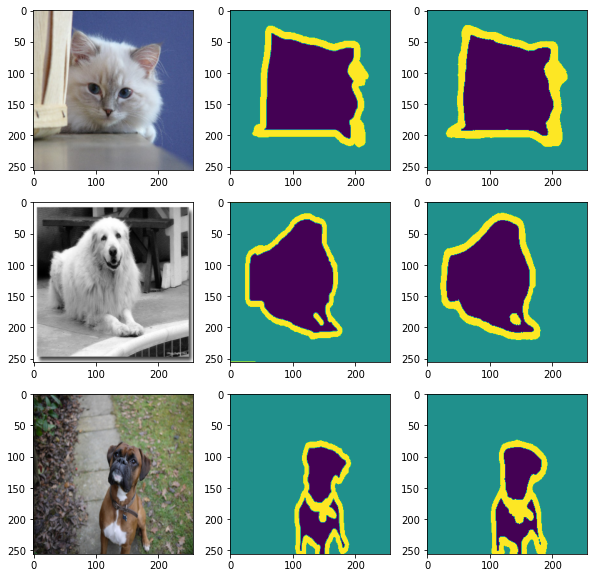

In [39]:
image, mask = next(iter(train_dl))
pred_mask = my_model(image)

plt.figure(figsize=(10, 10))
for i in range(num):
    plt.subplot(num, 3, i*num+1)
    plt.imshow(image[i].permute(1,2,0).cpu().numpy())
    plt.subplot(num, 3, i*num+2)
    plt.imshow(mask[i].cpu().numpy())
    plt.subplot(num, 3, i*num+3)
    plt.imshow(torch.argmax(pred_mask[i].permute(1,2,0), axis=-1).detach().numpy())